In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import scipy.io as io
import pandas as pd
from scipy import ndimage
from scipy.interpolate import interp1d

## Patch Hyperspectral Reflectance

Text(0.5, 0, 'wavelength [nm]')

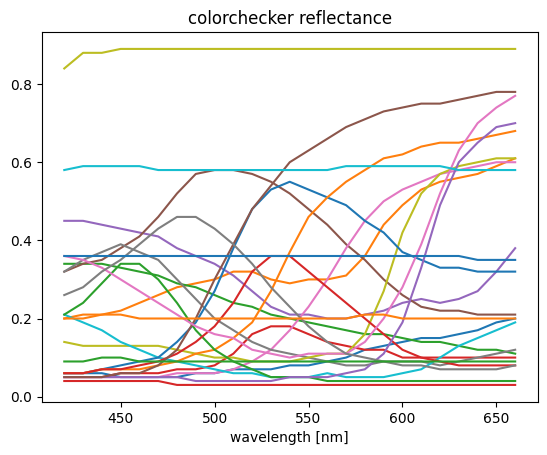

In [2]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max:2] 
ref_CC = ref_CC[ind_min:ind_max:2,:]

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2])
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [3]:
# blue = ref_CC[1:-2,12] 
# green = ref_CC[1:-2,13] 
# red = ref_CC[1:-2,14] 
# white = ref_CC[1:-2,18]

## ldr2hdr

In [4]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(420, 670, 10)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

### Gamma correction

In [5]:
# # load gamma rgb fitting coefficients
# rgb_fit = io.loadmat("./calibration/gamma_correction.mat")

# # define coefficients for all rgb channel
# a = rgb_fit['a']
# b = rgb_fit['b']
# c = rgb_fit['c']

# # gamma correction
# y = a*(y_linear**b)+c

# # stack for 3 channels
# rgb_gamma_corrected = y

### ldr2hdr Preprocess

In [6]:
# date of datas
date = "0913"

# exposure time
ex_time = np.array([160, 280])
# ex_time = np.array([160, 280, 390])
ex_min = ex_time[0]
exposure = ex_time / ex_min

# rgb intensity
# intensity = np.array([0.2, 0.8, 0.8])
intensity = np.array([0.2, 0.8])

ldr2hdr_dir = "./calibration/ldr2hdr/2023%s/"%date

# center points for all patches
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])

# black patch
last_row_center_pts = np.array([800,495])

In [7]:
# safe subtraction for uint16
def safe_subtract(a,b):
    # difference = np.abs(a.astype(np.int16) - b.astype(np.int16))
    
    difference = np.where(a>b, a-b, 0)
    difference = np.clip(np.round(difference), 0, 65535).astype(np.uint16)    
    
    return difference.astype(a.dtype)

In [8]:
# radiance weight for intensity normalization
def cal_radiance_weight(exp_images_bgrm): # exposure 개수, H, W, 3
    radiance_values = np.zeros(shape=(len(exp_images_bgrm), 3))
    
    p_size = 20
    
    for i in range(len(exp_images_bgrm)):
        y_idx_start, y_idx_end = (last_row_center_pts[1] - p_size//2).astype(np.int32), (last_row_center_pts[1] + p_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (last_row_center_pts[0] - p_size//2).astype(np.int32), (last_row_center_pts[0] + p_size//2).astype(np.int32)
        
        radiance_values[i] = exp_images_bgrm[i][y_idx_start:y_idx_end, x_idx_start:x_idx_end].mean(axis = (0,1))
    
    return (radiance_values / radiance_values[0])

# calculate radiance_weight
exp_img_path = os.path.join(ldr2hdr_dir, 'intensity_%d_white_crop/calibration00/capture_%04d.png')
exp_img_black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

exp_images = np.array([cv2.imread(exp_img_path%(intensity[k]*100, 0), -1)[:,:,::-1] for k in range(len(intensity))])
exp_black_images = np.array([cv2.imread(exp_img_black_path%(160, 0), -1)[:,:,::-1] for k in ex_time])

# remove black image
exp_images_bgrm = safe_subtract(exp_images, exp_black_images)

# radiance weight calculation
radiance_weight = cal_radiance_weight(exp_images_bgrm)

In [9]:
1/radiance_weight

array([[1.        , 1.        , 1.        ],
       [0.04095889, 0.04477243, 0.04151389]])

In [10]:
# assumes that we have the uint16 LDR images 
# image intensity weight

invalid_intensity_ratio = 0.02 # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv:
        weight_trapezoid[i] = 0  
    elif i < intv * 2:
        weight_trapezoid[i] = (i - intv) / intv
    elif i < max_intensity - (intv * 2):
        weight_trapezoid[i] = 1
    elif i < max_intensity - intv:
        weight_trapezoid[i] = (max_intensity - intv - i) / intv
    else:
        weight_trapezoid[i] = 0

In [11]:
# assumes that we have the uint16 LDR images 
# black removed image intensity weight

invalid_intensity_ratio = 0.02  # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid_bgrm = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv: # 3 
        weight_trapezoid_bgrm[i] = 0  
    elif i < intv * 2:
        weight_trapezoid_bgrm[i] = (i - intv) / intv
    else:
        weight_trapezoid_bgrm[i] = 1

In [12]:
def make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure):
    
    # weighted images for ldr image and black image removed ldr image
    # black image를 뺀 애는 saturation이 일어난 ldr image에서 intensity가 내려가기 때문에 사실 
    # saturation이 일어나서 얘를 weight 를 0을 줘야함. 근데 bgrm에만 기준으로 weight가 정해지면
    # saturation 일어난 애에서 제거가 불가능
    weighted_images = [weight_trapezoid[image] for image in ldr_images]
    weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]
    
    # take the minimum weight 
    weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)
    
    # exposure normalization
    radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

    # intensity normalization
    weight_sum_image = np.sum(weighted_images_final, axis=0)
    radiance_sum_image = np.sum(radiance_images, axis=0)

    idx_invalid = (weight_sum_image == 0)
    weight_sum_image[idx_invalid] = 1
    radiance_sum_image[idx_invalid] = 0    
    
    return np.divide(radiance_sum_image, weight_sum_image), idx_invalid, weight_sum_image

#### Raidance weight debugging

original :  [3.38823529 6.02352941 4.51764706]
normalized :  [3.38823529 6.02352941 4.51764706]
original :  [ 77.49019608 137.97647059  92.10980392]
normalized :  [3.17391217 6.17754202 3.82383628]


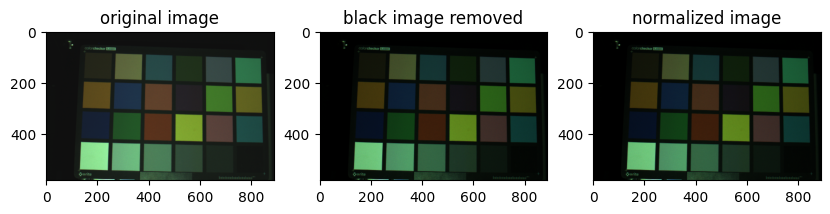

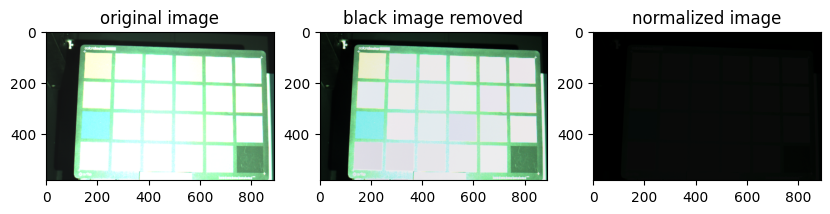

In [13]:
for i in range(len(exp_images)):
    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(exp_images[i]/65535), plt.title('original image')
    plt.subplot(132), plt.imshow((exp_images_bgrm[i]/ 65535)), plt.title('black image removed')
    plt.subplot(133), plt.imshow((exp_images_bgrm[i]*(1/radiance_weight[i]))/ 65535), plt.title('normalized image')
    
    print('original : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]]/ 255))
    print('normalized : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]] * (1/radiance_weight[i]))/ 255)

#### Debugging

In [13]:
ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

i = 201

ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in ex_time])
ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])

ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)

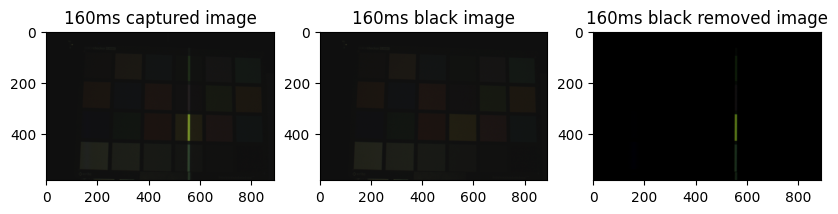

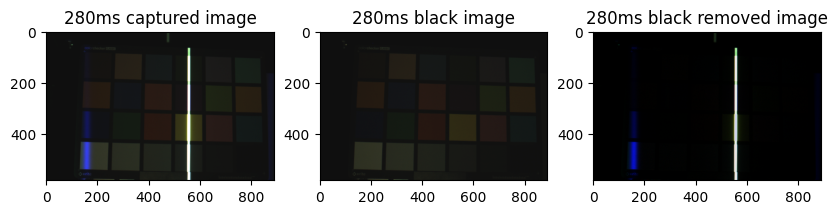

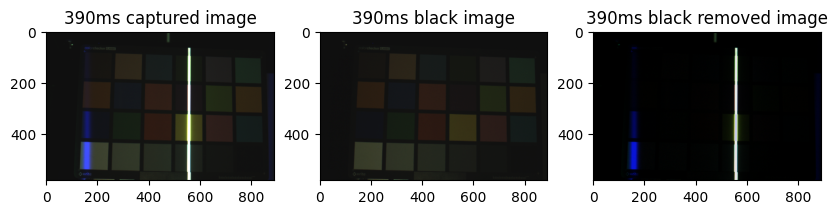

In [14]:
for i in range(len(ldr_images)):
    plt.figure(figsize=(10,5))
    plt.subplot(131),plt.imshow(ldr_images[i]/65535.), plt.title('%sms captured image'%ex_time[i])
    plt.subplot(132), plt.imshow(ldr_black_images[i]/65535.), plt.title('%sms black image'%ex_time[i])
    plt.subplot(133),plt.imshow(ldr_images_bgrm[i]/65535.), plt.title('%sms black removed image'%ex_time[i])

In [22]:
# for i in range(3):
#     plt.figure()
#     normalized_image = (ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i]))/65535
#     plt.imshow(normalized_image)
    
#     print('original %sms'%ex_time[i])
#     print('black patch', ldr_images_bgrm[i,497,777]/65535 * 255.)
#     print('green dispersed patch', ldr_images_bgrm[i,488,309]/65535 * 255.)
    
#     print('normalized %sms'%ex_time[i])
#     print('black patch', normalized_image[497,777] * 255.)
#     print('green dispersed patch', normalized_image[488,309] * 255.)
    
#     print('\n')

In [15]:
#### 왜 weighted images가 필요한지
weighted_images = [weight_trapezoid[image] for image in ldr_images]
weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]

weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)

# exposure weight, radiance weight 
# normalization 및 weight multiplication
radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

weight_sum_image = np.sum(weighted_images_final, axis=0)
radiance_sum_image = np.sum(radiance_images, axis=0)

idx_invalid = (weight_sum_image == 0)
weight_sum_image[idx_invalid] = 1
radiance_sum_image[idx_invalid] = 0 

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x19fb28f7488>)

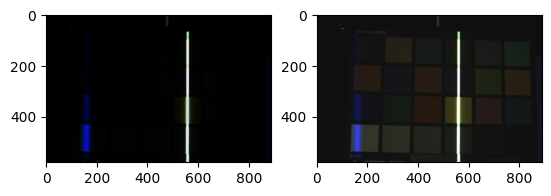

In [16]:
plt.subplot(121), plt.imshow(ldr_images_bgrm[1]/65535)
plt.subplot(122), plt.imshow(ldr_images[1]/65535)

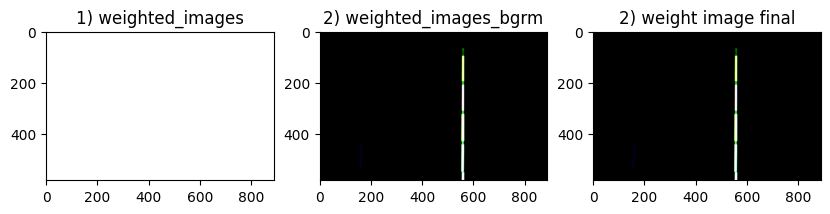

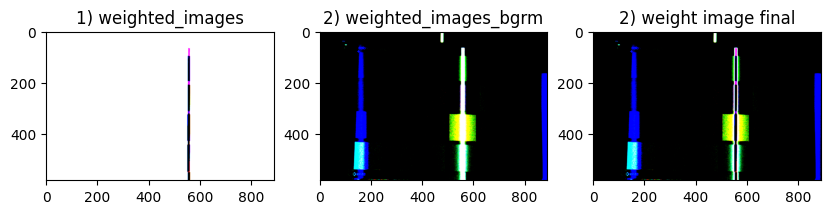

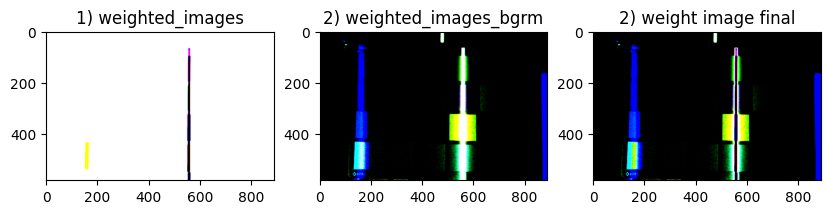

In [17]:
for i in range(len(ldr_images)):
    plt.figure(figsize = (10,5))
    plt.subplot(131), plt.imshow(weighted_images[i]), plt.title('1) weighted_images')
    plt.subplot(132), plt.imshow(weighted_images_bgrm[i]), plt.title('2) weighted_images_bgrm')
    plt.subplot(133), plt.imshow(weighted_images_final[i]), plt.title('2) weight image final')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


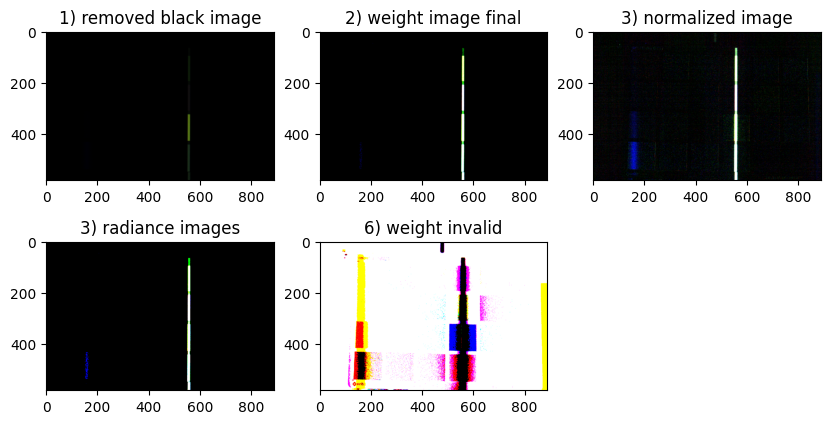

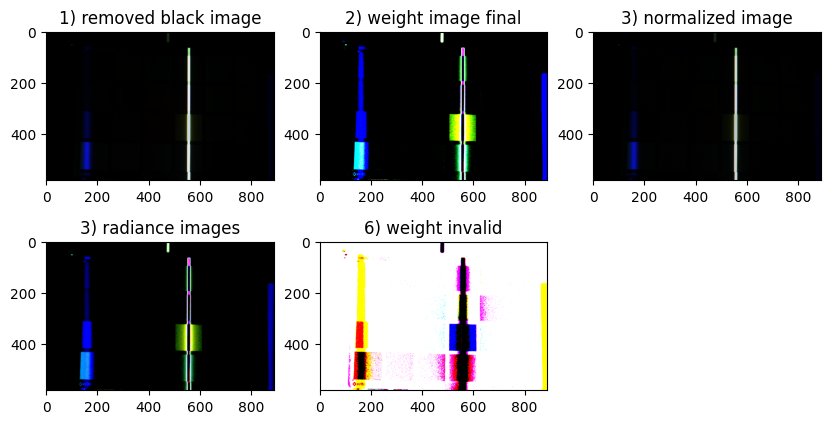

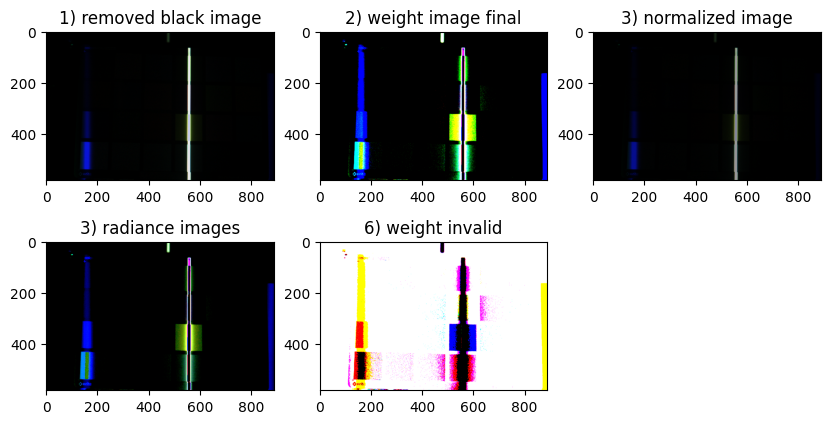

In [18]:
for i in range(len(ldr_images)):
    plt.figure(figsize = (10,5))
    plt.subplot(231), plt.imshow(ldr_images_bgrm[i] /65535), plt.title('1) removed black image')
    plt.subplot(232), plt.imshow(weighted_images_final[i]), plt.title('2) weight image final')
    plt.subplot(233), plt.imshow((ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i]))/ 100000), plt.title('3) normalized image')
    plt.subplot(234), plt.imshow(radiance_images[i]/10000), plt.title('3) radiance images')

    plt.subplot(235), plt.imshow(idx_invalid.astype(np.uint8)*255), plt.title('6) weight invalid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'4) HDR / HDR.max()'}>,
 Text(0.5, 1.0, '4) HDR / HDR.max()'))

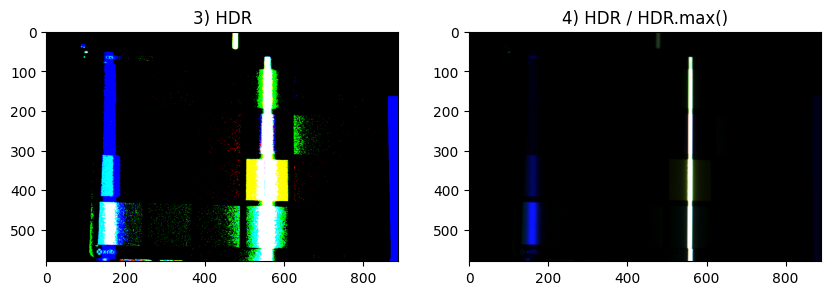

In [19]:
plt.figure(figsize = (10,5))
# plt.subplot(141), plt.imshow(radiance_sum_image), plt.title('1) radiance sum image')
# plt.subplot(142), plt.imshow(weight_sum_image / 3), plt.title('2) weight sum image')
hdr = radiance_sum_image / weight_sum_image
plt.subplot(121), plt.imshow(hdr), plt.title('3) HDR')
plt.subplot(122), plt.imshow(hdr/65535), plt.title('4) HDR / HDR.max()')

In [27]:
hdr_img = np.divide(radiance_sum_image, weight_sum_image)

In [28]:
hdr_img.max(), hdr_img.min()

(53196.0, 0.0)

In [29]:
hdr_img.max()

53196.0

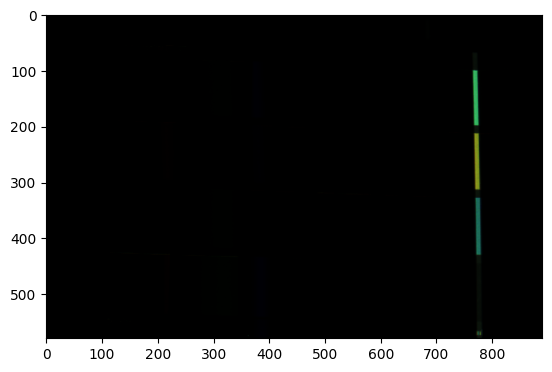

In [32]:
plt.imshow(hdr_img/65535)

### Make Hdr Image

In [14]:
hdr_imgs = []

# erase black image and get hdr image
for i in range(n_illum):    
    ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
    black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

    ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in ex_time])
    ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])
    
    # print(ldr_images.max(), ldr_images.min(), ldr_black_images.max(), ldr_black_images.min())    
    
    ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)
    
    # print(final_ldr_images.max(), final_ldr_images.min())
        
    hdr_img, invalid_map, weight_map = make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure)
    hdr_imgs.append(hdr_img)

    if i % 10 == 0:
        print('%03d-th finished'%i)

hdr_imgs = np.array(hdr_imgs)

000-th finished
010-th finished
020-th finished
030-th finished
040-th finished
050-th finished
060-th finished
070-th finished
080-th finished
090-th finished
100-th finished
110-th finished
120-th finished
130-th finished
140-th finished
150-th finished
160-th finished
170-th finished
180-th finished
190-th finished
200-th finished
210-th finished
220-th finished
230-th finished
240-th finished
250-th finished
260-th finished
270-th finished
280-th finished
290-th finished
300-th finished
310-th finished


### For only 1 exposure

In [15]:
hdr_imgs_1 = []

exp_indx = 1

for i in range(318): 
    ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
    black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

    ldr_images = np.array(cv2.imread(ldr_path%(ex_time[exp_indx], i), -1)[:,:,::-1])
    ldr_black_images = np.array(cv2.imread(black_path%(ex_time[exp_indx], 0), -1)[:,:,::-1])

    # print(ldr_images.max(), ldr_images.min(), ldr_black_images.max(), ldr_black_images.min())    

    final_ldr_images = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    final_ldr_images = final_ldr_images.astype(np.uint16)
    
    # ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    # ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)
    
    # ldr_images = ldr_images[np.newaxis,:,:,:]
    # ldr_images_bgrm = ldr_images_bgrm[np.newaxis,:,:,:]
    
    # hdr_img, invalid_map, weight_map = make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure)
    # hdr_imgs_1.append(hdr_img)

    # if i % 10 == 0:
    #     print('%03d-th finished'%i)

    hdr_imgs_1.append(final_ldr_images)
hdr_imgs_1 = np.array(hdr_imgs_1)

KeyboardInterrupt: 

### HDR Visualization Check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


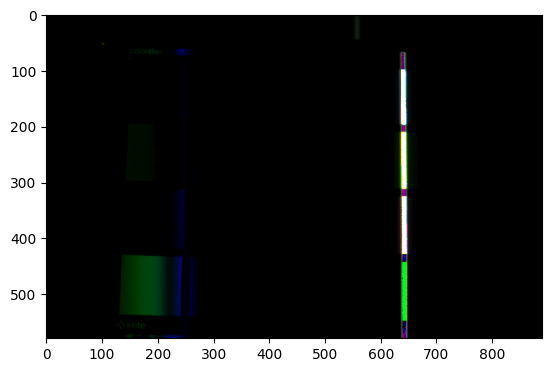

In [14]:
idx = 225
max_val = 65535
plt.imshow(hdr_imgs[idx] / (65535*2))

In [ ]:
# np.save('./hdr_step5.npy', hdr_imgs)

In [ ]:
# hdr_imgs = np.load('./hdr_step5.npy')

## RGB Intensity Plotting

In [16]:
final_hdr = hdr_imgs.transpose(1,2,0,3)
# final_hdr = hdr_imgs_1.transpose(1,2,0,3)

In [23]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, n_channel))
patches_idx = all_patches_center_pts

cnst = 1
patch_size = 3

# max value defined for each illumination pattern 

for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
        
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (final_hdr[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l] / (65535/40)).reshape(-1, 3).mean(axis = 0)
                patches_rgb_real[l, p] = rgb_intensity

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


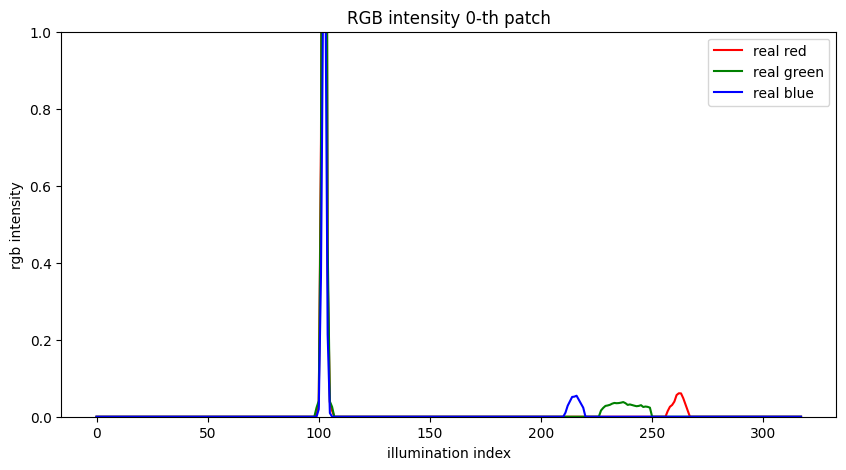

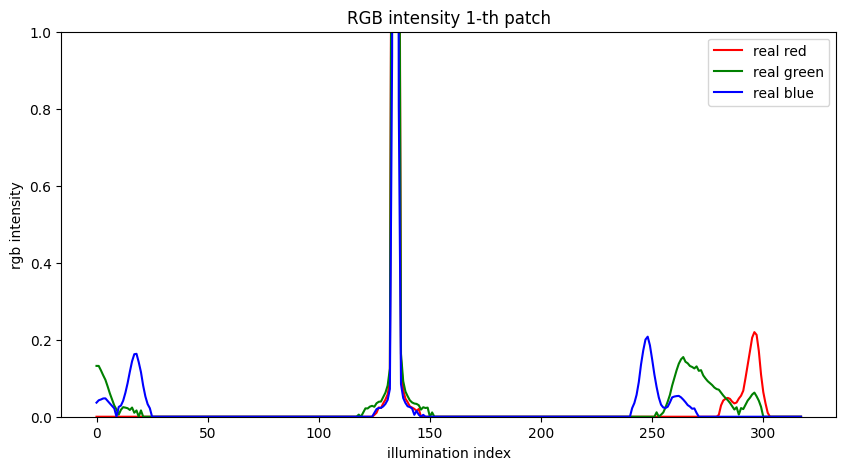

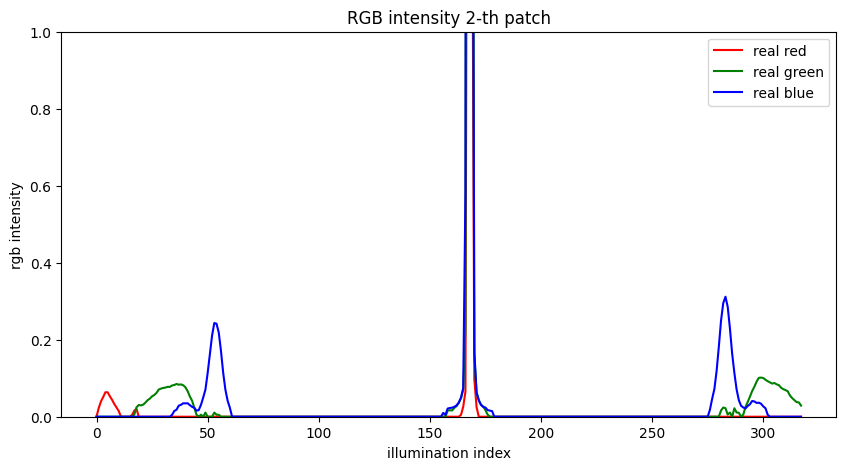

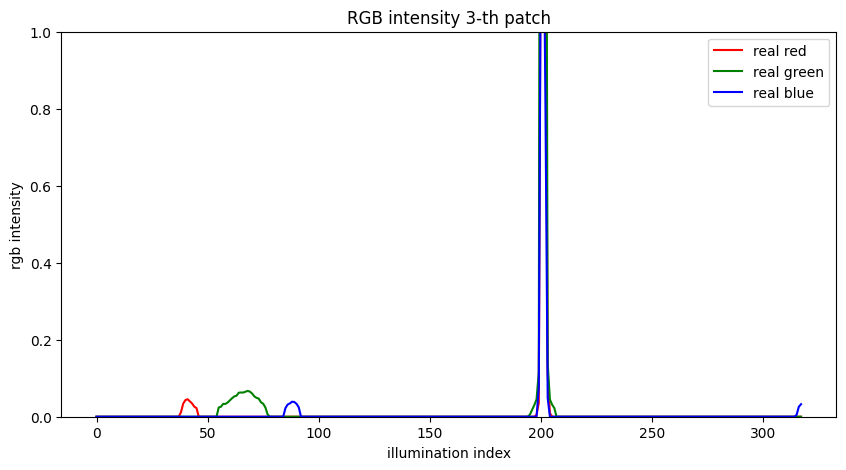

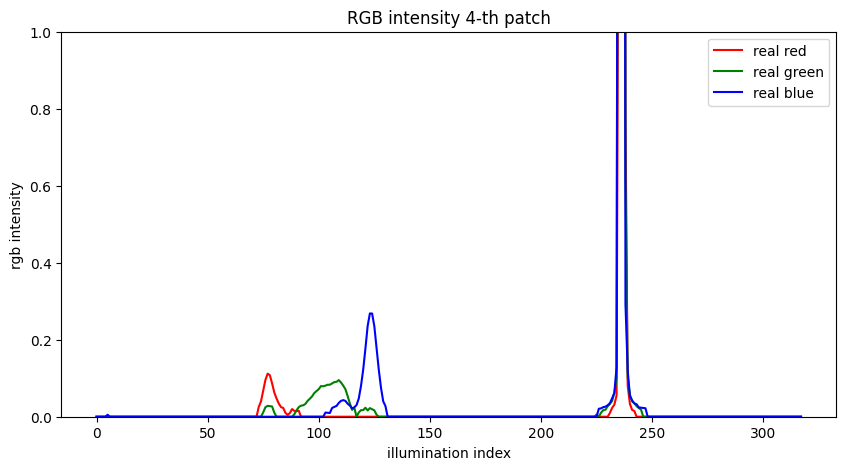

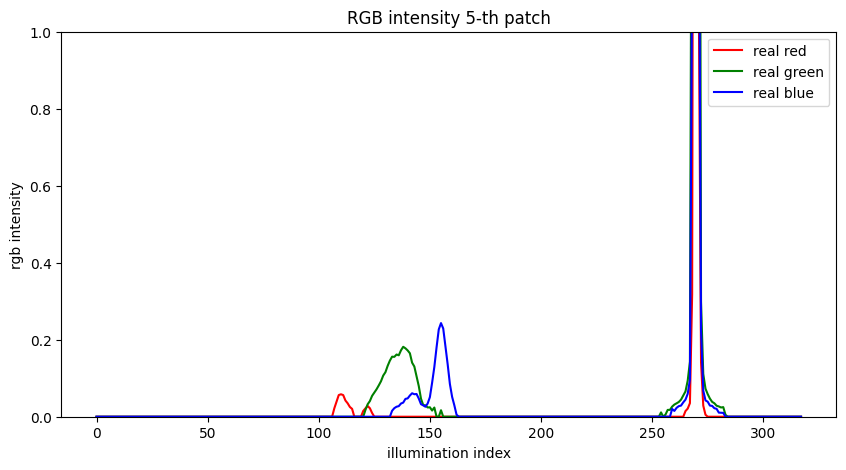

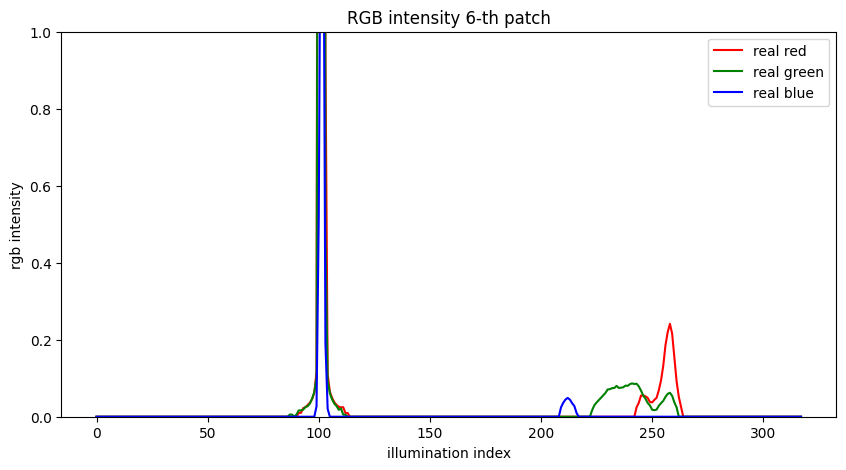

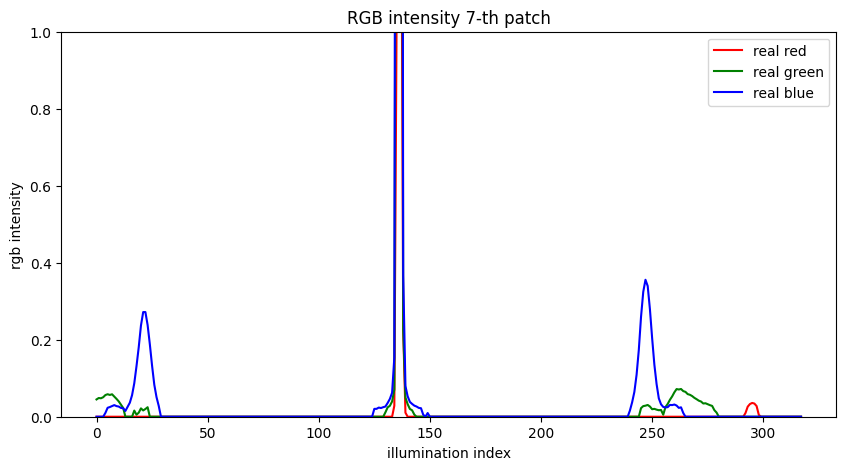

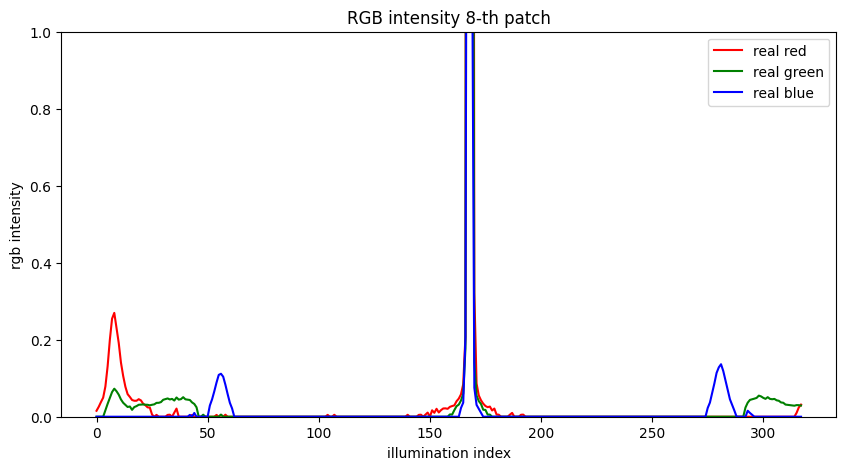

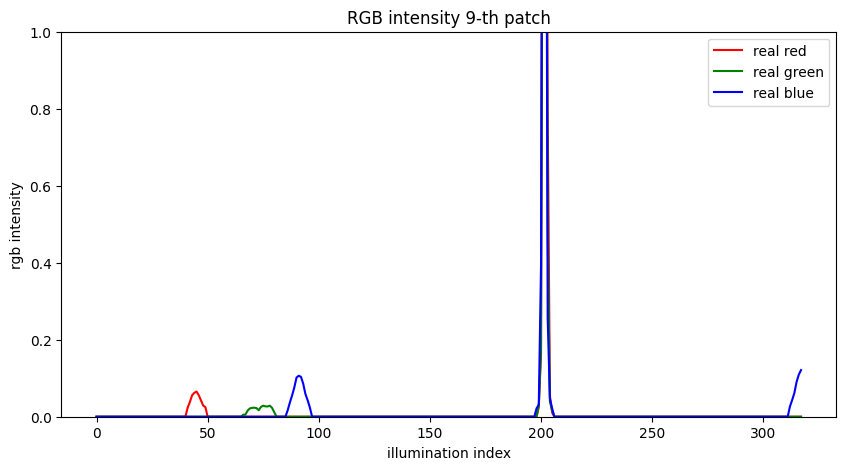

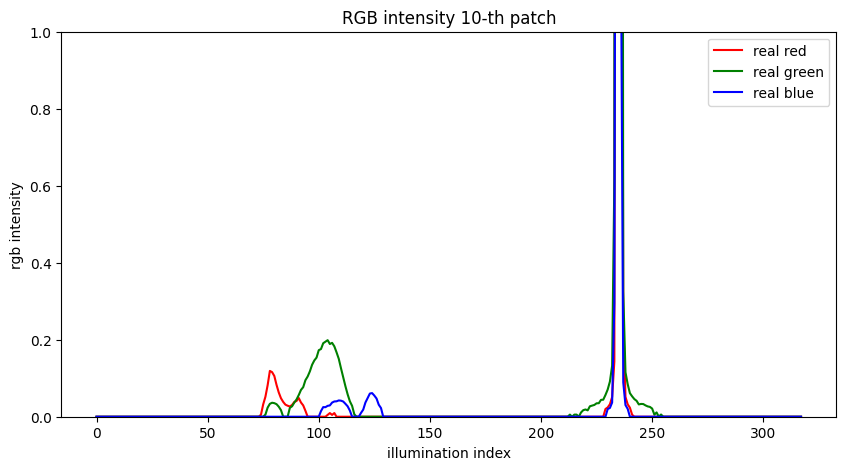

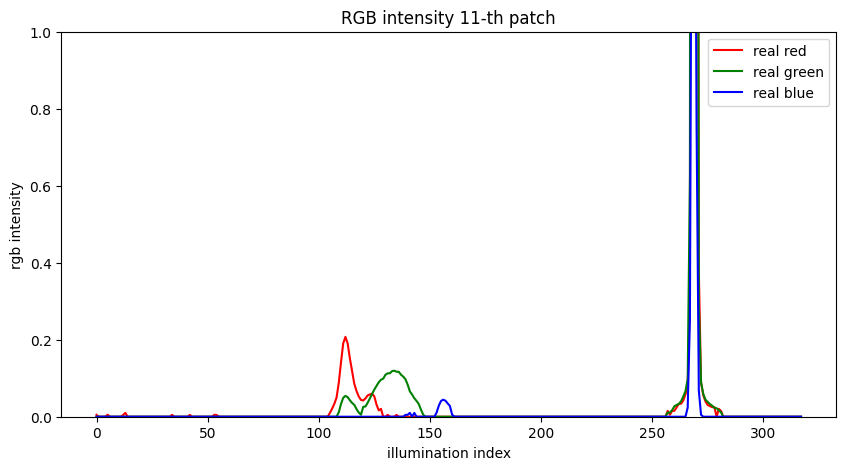

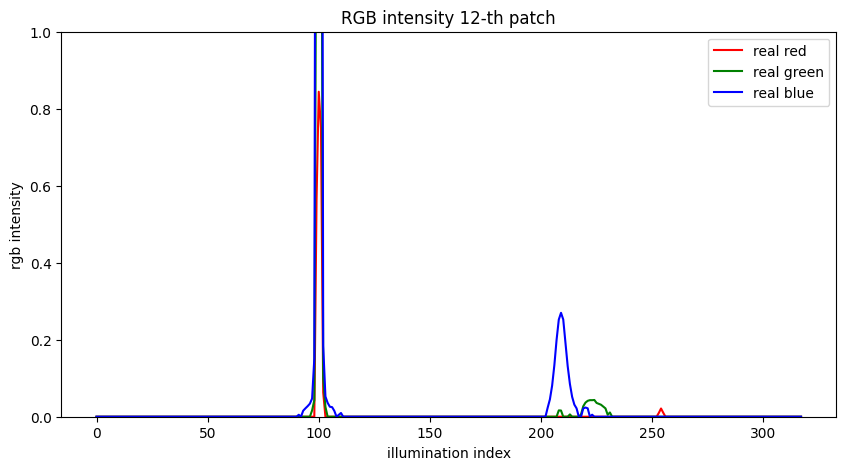

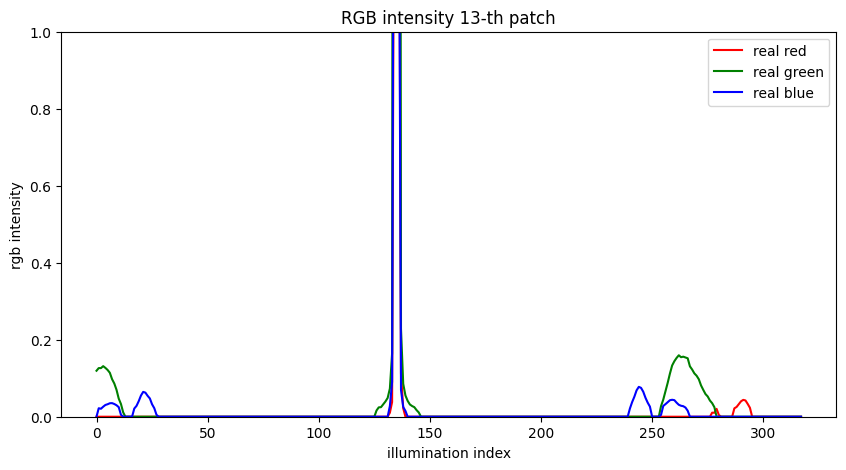

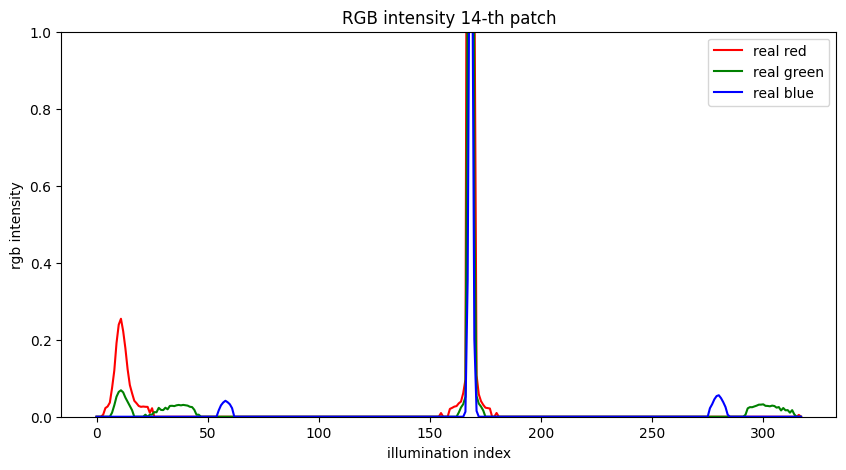

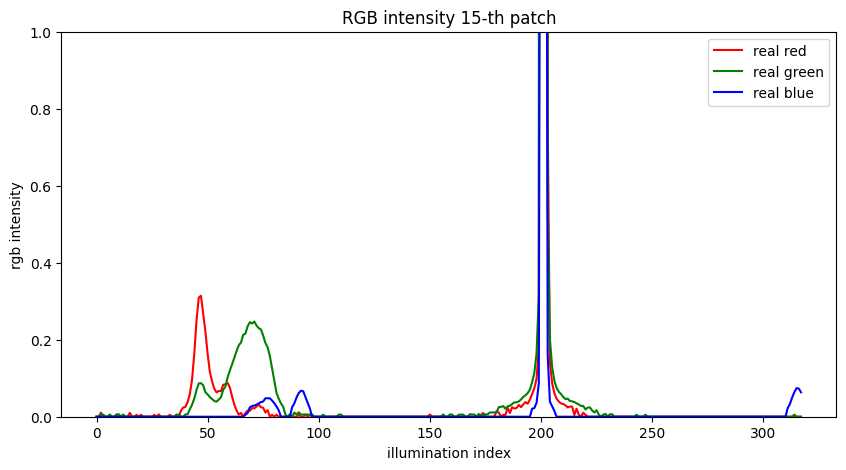

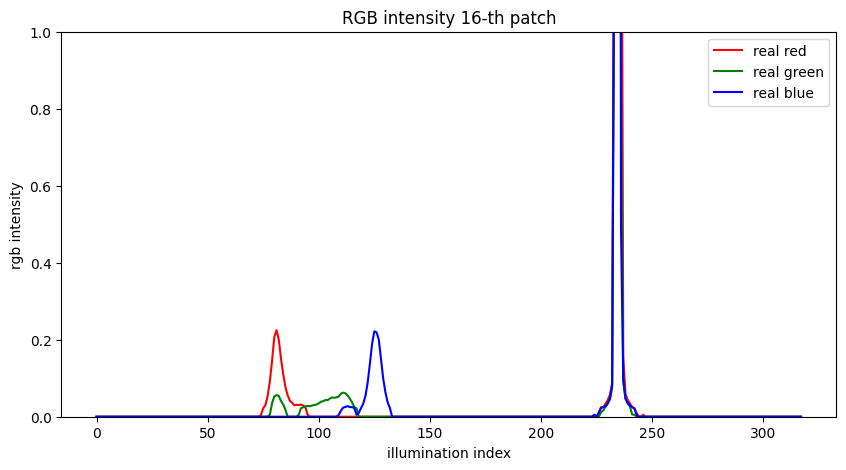

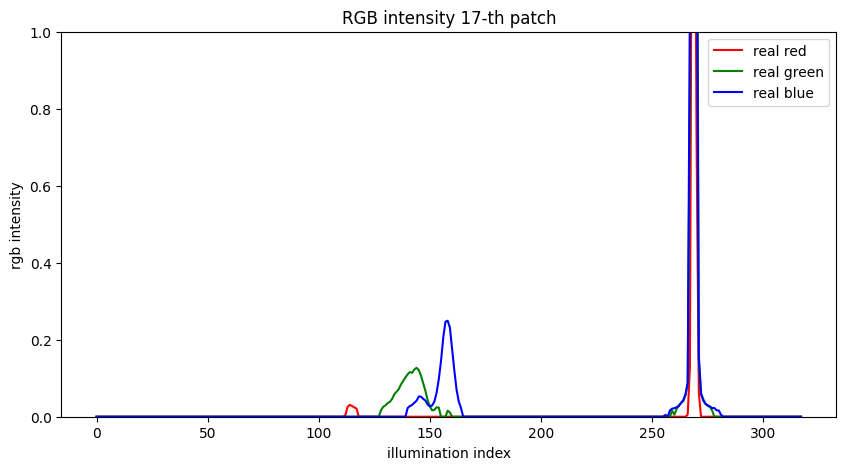

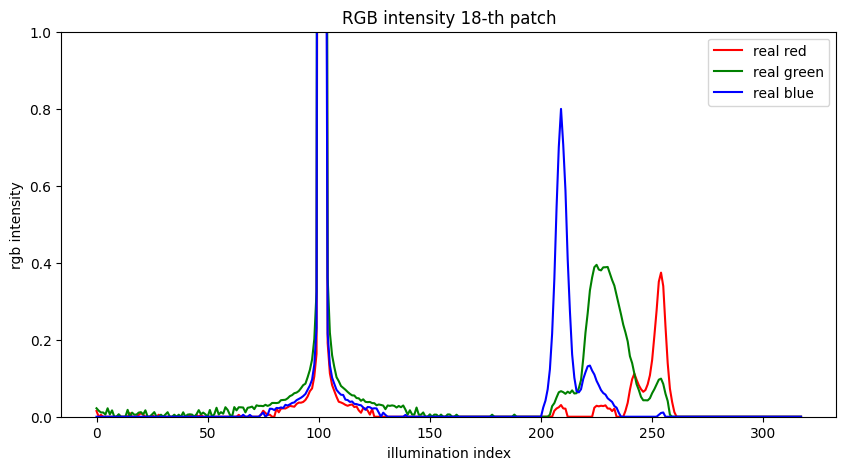

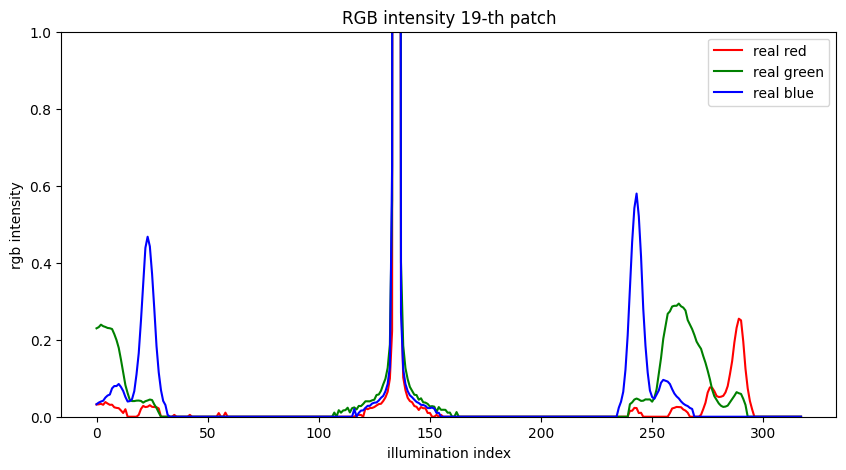

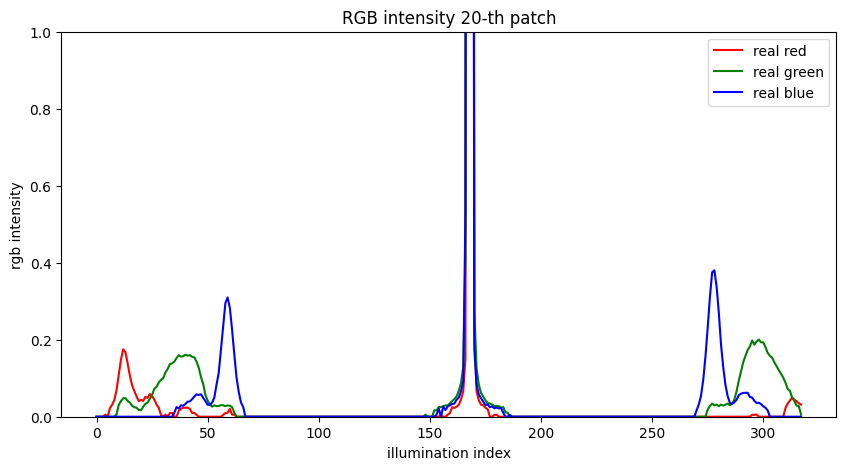

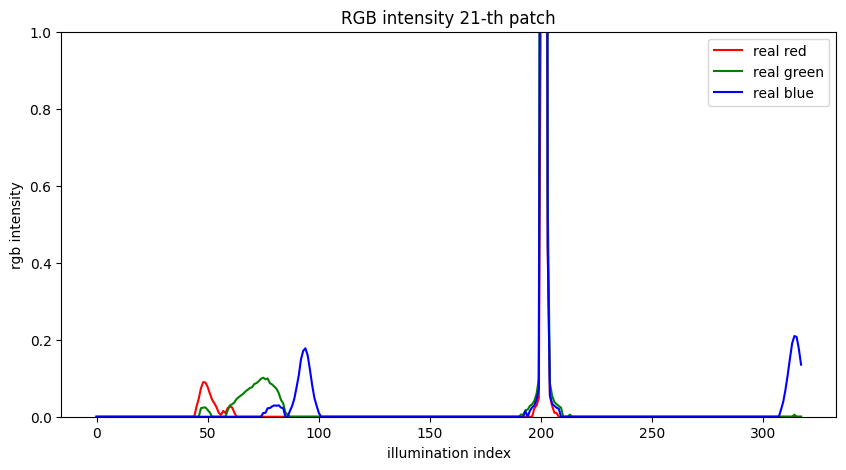

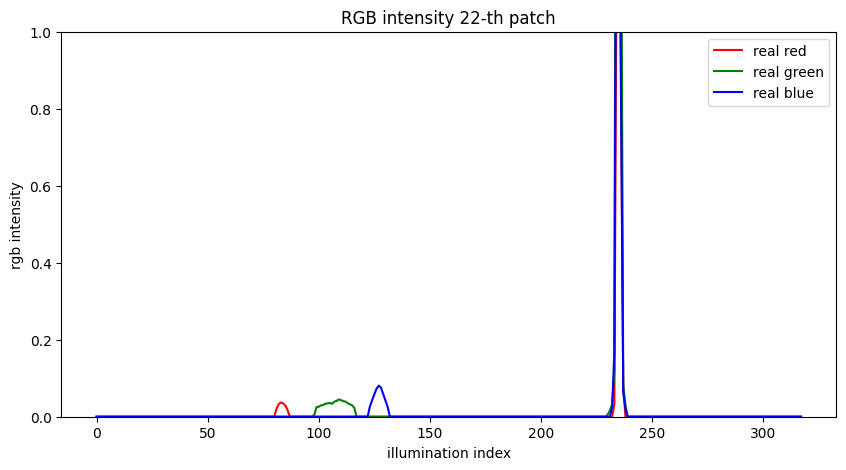

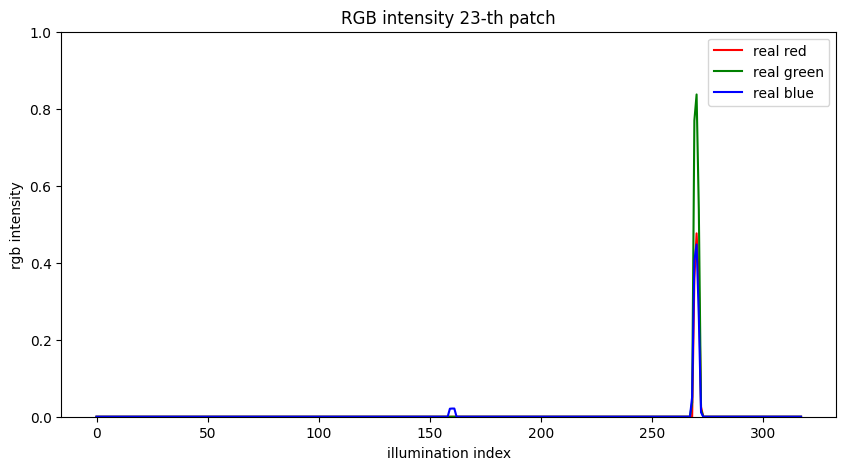

In [24]:
illum = np.arange(0, 318, 1)

start_idx = 0
end_idx = 318

for p in range(n_patches):
    plt.figure(figsize = (10,5))

    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 0], label = 'real red', c = 'red'), plt.legend(), plt.ylim(0,1)
    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 1], label = 'real green', c = 'green'), plt.legend(), plt.ylim(0,1)
    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 2], label = 'real blue', c = 'blue'), plt.legend(), plt.ylim(0,1)

    plt.title('RGB intensity %s-th patch'%patch_idx[p])
    plt.xlabel('illumination index')
    plt.ylabel('rgb intensity')
    
    # plt.savefig('./%sms_%02d-th_patch.png'%(ex_time[exp_indx],patch_idx[p]))

## Hyperspectral Reconstruction Feasibility Test

In [ ]:
dg_intensity = np.load('./dataset/image_formation/20230825_intensity_dg.npy')

(25,)


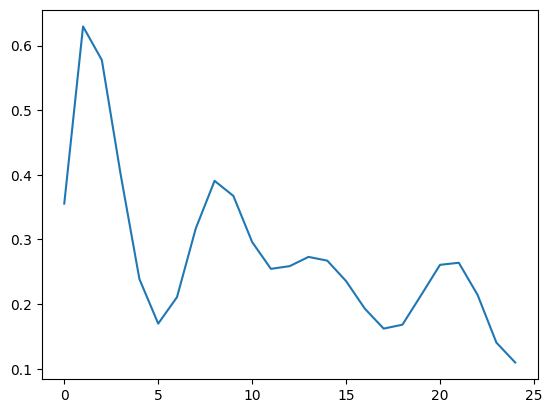

In [ ]:
print(dg_intensity.shape)
plt.plot(dg_intensity)

In [ ]:
# CRF PEF constant
radio_constant = np.load('./calibration/radiometric_cal/opt_params/opt_param_detach_%05d.npy'%9500)

# bring initial value of PEF and CRF
PEF = np.load('./dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[2:27] #* radio_constant[:,:3]
PEF = PEF[2:27] * 0.5

CRF = np.load('./dataset/image_formation/CRF.npy').T #* radio_constant[:,3:]

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x21901c14d88>])

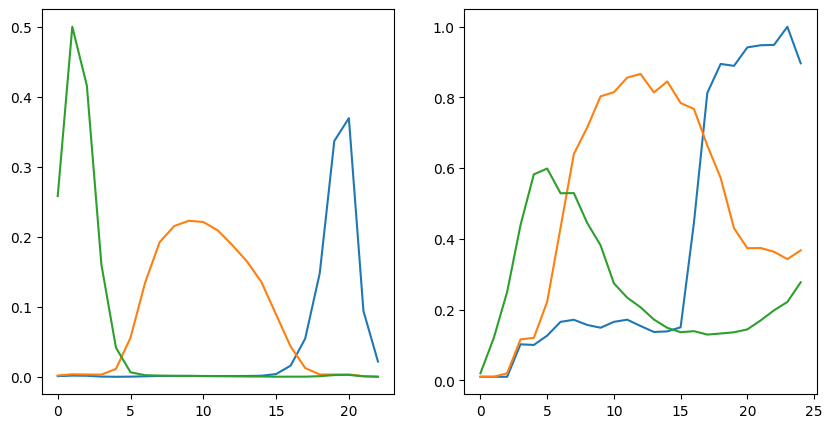

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.plot(PEF)
plt.subplot(122), plt.plot(CRF)

In [ ]:
# white pattern
white_patt = np.ones(shape = (1, 3))
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

In [ ]:
# test with GT reflectance for all patches
total_patch = []
for p in range(n_patches):
    I_C = ref_CC[1:-2,p][:,np.newaxis] * CRF * white_patt_hyp[:,np.newaxis] * dg_intensity[:,np.newaxis]
    total_patch.append(I_C)

ValueError: operands could not be broadcast together with shapes (25,3) (23,1) 

IndexError: list index out of range

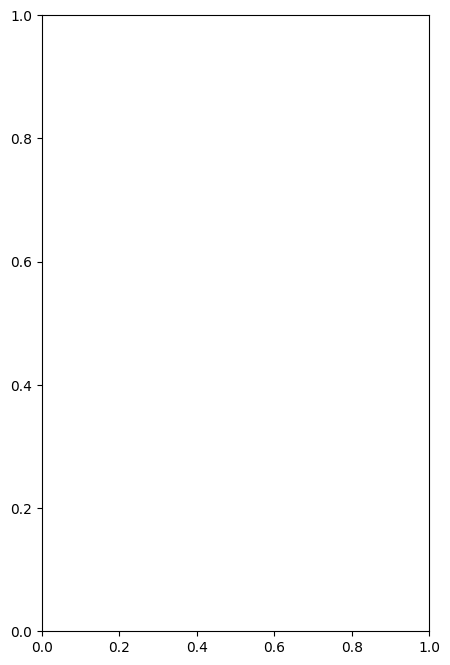

In [ ]:
constant = 10

# plot 1st order rgb intensity for all patches
for p in range(n_patches):
    plt.figure(figsize=(5,8))
    plt.ylim([0, 1])
    plt.plot(total_patch[p][:,0] * constant, c = 'red', label = 'red')
    plt.plot(total_patch[p][:,1] * constant, c = 'green', label = 'green')
    plt.plot(total_patch[p][:,2] * constant, c = 'blue', label = 'blue')
    plt.title('%s-th patch'%p)
    plt.legend()

## Hyperspectral Reconstruction

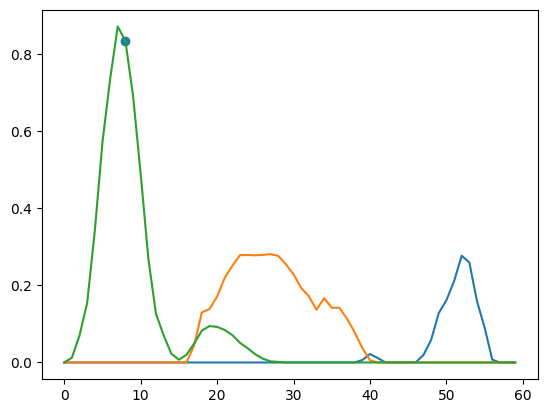

In [ ]:
# white
patch_num = 18
start_idx, end_idx = 195, 255
patch_range = np.arange(start_idx, end_idx+1)

idx = 8

plt.plot(patches_rgb_real[start_idx:end_idx, patch_num]) # 78 ~ 102 총 25개
plt.scatter(idx, patches_rgb_real[patch_range[idx], patch_num, 2])

In [ ]:
patch_range[15]

210

In [ ]:
interval_array = np.linspace(start_idx, end_idx, 25)
interval_array = np.round(interval_array).astype(np.int16)
print(interval_array)

[195 198 200 202 205 208 210 212 215 218 220 222 225 228 230 232 235 238
 240 242 245 248 250 252 255]


In [ ]:
R = patches_rgb_real[interval_array, patch_num]

In [ ]:
R.min()

0.0

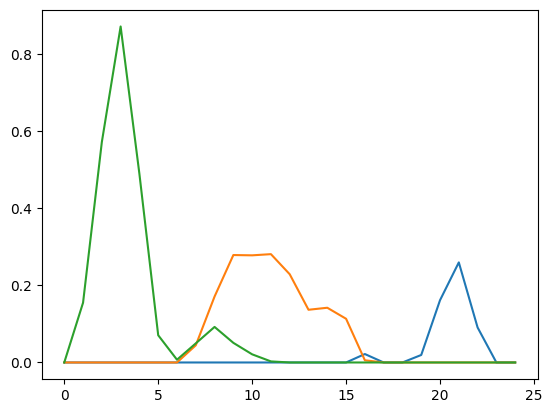

In [ ]:
plt.plot(R)

In [ ]:
# summation of CRF RGB channel
CRF_sum = CRF.sum(axis = 1)

# summation of Image RGB channel
I_C = R.sum(axis = 1)

In [ ]:
hyp_ref = (I_C / ( CRF_sum * white_patt_hyp * dg_intensity))

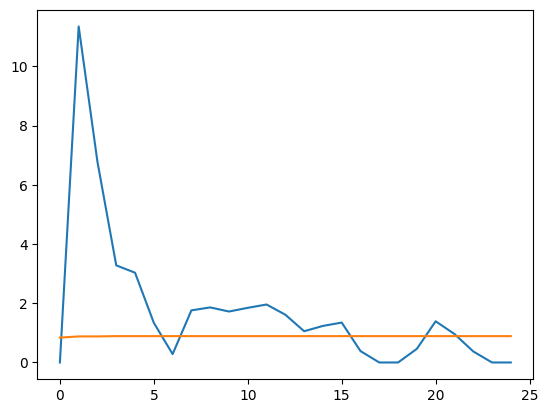

In [ ]:
# plt.ylim([0,1])
plt.plot(hyp_ref)
plt.plot(ref_CC[1:-2,patch_num])

### 